# Beginner Tutorial: Recommender Systems in Python

Source: https://www.datacamp.com/community/tutorials/recommender-systems-python

Aditya Sharma, May 30th 2020

Broadly, recommender systems can be classified into 3 types:

- Simple recommenders: offer generalized recommendations to every user, based on movie popularity and/or genre. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience. An example could be IMDB Top 250.
- Content-based recommenders: suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person likes a particular item, he or she will also like an item that is similar to it. And to recommend that, it will make use of the user's past item metadata. A good example could be YouTube, where based on your history, it suggests you new videos that you could potentially watch.
- Collaborative filtering engines: these systems are widely used, and they try to predict the rating or preference that a user would give an item-based on past ratings and preferences of other users. Collaborative filters do not require item metadata like its content-based counterparts.

---

## Simple Recommenders

Simple recommenders are basic systems that recommend the top items based on a certain metric or score. In this section, you will build a simplified clone of IMDB Top 250 Movies using metadata collected from IMDB.

The following are the steps involved:

- Decide on the metric or score to rate movies on.

- Calculate the score for every movie.

- Sort the movies based on the score and output the top results.

In [1]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Jul 30 13:10 kaggle.json


In [2]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Copy the movies data set locally.
!kaggle datasets download -d rounakbanik/the-movies-dataset

the-movies-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
with zipfile.ZipFile('/content/the-movies-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/the-movies-dataset')

In [6]:
import pandas as pd

metadata = pd.read_csv('./the-movies-dataset/movies_metadata.csv', low_memory=False)

metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


However, using a rating as a metric has a few caveats:

- For one, it does not take into consideration the popularity of a movie. Therefore, a movie with a rating of 9 from 10 voters will be considered 'better' than a movie with a rating of 8.9 from 10,000 voters.

    For example, imagine you want to order Chinese food, you have a couple of options, one restaurant has a 5-star rating by only 5 people while the other restaurant has 4.5 ratings by 1000 people. Which restaurant would you prefer? The second one, right?

    Of course, there could be an exception that the first restaurant opened just a few days ago; hence, fewer people voted for it while, on the contrary, the second restaurant is operational for a year.

- On a related note, this metric will also tend to favor movies with a smaller number of voters with skewed and/or extremely high ratings. As the number of voters increases, the rating of a movie regularizes and approaches towards a value that is reflective of the movie's quality and gives the user a much better idea as to which movie he/she should choose. While it is difficult to discern the quality of a movie with extremely few voters, you might have to consider external sources to conclude.

Taking these shortcomings into consideration, you must come up with a weighted rating that takes into account the average rating and the number of votes it has accumulated. Such a system will make sure that a movie with a 9 rating from 100,000 voters gets a (far) higher score than a movie with the same rating but a mere few hundred voters.

$$ 
\begin{equation}
\text Weighted Rating (\bf WR) = \left({{\bf v} \over {\bf v} + {\bf m}} \cdot R\right) + \left({{\bf m} \over {\bf v} + {\bf m}} \cdot C\right)
\end{equation}
$$

In the above equation,

v is the number of votes for the movie;

m is the minimum votes required to be listed in the chart;

R is the average rating of the movie;

C is the mean vote across the whole report.

Determining an appropriate value for m is a hyperparameter that you can choose accordingly since there is no right value for m. You can consider it as a preliminary negative filter that will simply remove the movies which have a number of votes less than a certain threshold m. The selectivity of your filter is up to your discretion.

In this tutorial, you will use cutoff m as the 90th percentile. In other words, for a movie to be featured in the charts, it must have more votes than at least 90% of the movies on the list. (On the other hand, if you had chosen the 75th percentile, you would have considered the top 25% of the movies in terms of the number of votes garnered. As percentile decreases, the number of movies considered will increase).

In [7]:
C = metadata['vote_average'].mean()
print(C)

5.618207215133889


In [8]:
m = metadata['vote_count'].quantile(0.9)
m

160.0

In [9]:
# Just take the qualified data points
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
q_movies.shape

(4555, 24)

Next and the most important step is to calculate the weighted rating for each qualified movie. To do this, you will:

- Define a function, weighted_rating();
- Since you already have calculated m and C you will simply pass them as an argument to the function;
- Then you will select the vote_count(v) and vote_average(R) column from the q_movies data frame;
- Finally, you will compute the weighted average and return the result.

In [10]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m) * R) + (m / (m + v) * C)

In [11]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [12]:
q_movies['score'].head()

0    7.640253
1    6.820293
4    5.660700
5    7.537201
8    5.556626
Name: score, dtype: float64

In [13]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(20)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


## Content Based Recommender

### Plot Description Based Recommender

In [14]:
metadata['overview'].head(3)

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
Name: overview, dtype: object

The problem at hand is a Natural Language Processing problem. Hence you need to extract some kind of features from the above text data before you can compute the similarity and/or dissimilarity between them. To put it simply, it is not possible to compute the similarity between any two overviews in their raw forms. To do this, you need to compute the word vectors of each overview or document, as it will be called from now on.

You will compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document. This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document), and each column represents a movie, as before.

In its essence, the TF-IDF score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that frequently occur in plot overviews and, therefore, their significance in computing the final similarity score.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

# Replace NaN with an empty string
metadata['overview'] = metadata['overview'].fillna('')

# Vectorizing
tfidf_matrix = tfidf.fit_transform(metadata['overview'])

In [16]:
tfidf_matrix.shape

(45466, 75827)

With this matrix in hand, you can now compute a similarity score. There are several similarity metrics that you can use for this, such as the manhattan, euclidean, the Pearson, and the cosine similarity scores. Again, there is no right answer to which score is the best. Different scores work well in different scenarios, and it is often a good idea to experiment with different metrics and observe the results.

You will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. You use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate (especially when used in conjunction with TF-IDF scores, which will be explained later). Mathematically, it is defined as follows:

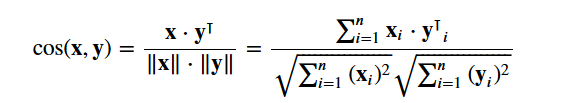

### Credits, Genres, and Keywords Based Recommender

The quality of your recommender would be increased with the usage of better metadata and by capturing more of the finer details. That is precisely what you are going to do in this section. You will build a recommender system based on the following metadata: the 3 top actors, the director, related genres, and the movie plot keywords.

The keywords, cast, and crew data are not available in your current dataset, so the first step would be to load and merge them into your main DataFrame metadata.

In [17]:
credits = pd.read_csv('./the-movies-dataset/credits.csv')
keywords = pd.read_csv('./the-movies-dataset/keywords.csv')

In [18]:
# Remove rows with bad IDs.
metadata = metadata.drop([19730, 29503, 35587])

# Convert IDs to int. Required for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')

# Merge keywords and credits into your main metadata dataframe
metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')

In [21]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(literal_eval)

In [22]:
# Import Numpy
import numpy as np

In [23]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [24]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [25]:
# Define new director, cast, genres and keywords features that are in a suitable form.
metadata['director'] = metadata['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(get_list)

In [26]:
# Print the new features of the first 3 films
metadata[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"


In [27]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [28]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    metadata[feature] = metadata[feature].apply(clean_data)

In [29]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [30]:
# Create a new soup feature
metadata['soup'] = metadata.apply(create_soup, axis=1)

In [31]:
metadata[['soup']].head(2)

,soup
0,jealousy toy boy tomhanks timallen donrickles ...
1,boardgame disappearance basedonchildren'sbook ...


In [33]:
metadata.loc[0, 'soup']

'jealousy toy boy tomhanks timallen donrickles johnlasseter animation comedy family'

In [35]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['soup'])

In [36]:
count_matrix.shape

(46628, 73881)

In [ ]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
# Reset index of your main DataFrame and construct reverse mapping as before
metadata = metadata.reset_index()
indices = pd.Series(metadata.index, index=metadata['title'])

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

## Collaborative Filtering with Python

Collaborative filters can further be classified into two types:

- User-based Filtering: these systems recommend products to a user that similar users have liked. For example, let's say Alice and Bob have a similar interest in books (that is, they largely like and dislike the same books). Now, let's say a new book has been launched into the market, and Alice has read and loved it. It is, therefore, highly likely that Bob will like it too, and therefore, the system recommends this book to Bob.

- Item-based Filtering: these systems are extremely similar to the content recommendation engine that you built. These systems identify similar items based on how people have rated it in the past. For example, if Alice, Bob, and Eve have given 5 stars to The Lord of the Rings and The Hobbit, the system identifies the items as similar. Therefore, if someone buys The Lord of the Rings, the system also recommends The Hobbit to him or her.